In [1]:
%matplotlib inline

import system_generation as sysgen
import median_methods as methods
import plots
import math
import numpy as np
import matplotlib.pyplot as plt


For the first few tests we'll use the same Gaussian system.

In [45]:
rows, cols = 50000, 100
beta = 0.2
errs = math.ceil(beta * rows);
A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
start = np.zeros(cols)
start_data = [A,b,start]

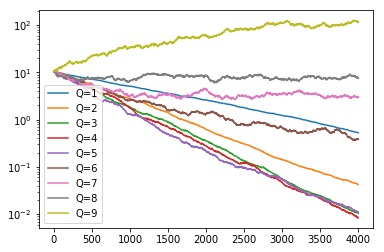

In [8]:
sgd_various_quantiles = [[methods.SampledQuantileSGD(*start_data, 
		quantile=q/10, samples=100),"Q="+str(q)] for q in range(1,10)]
plots.make_plot(sgd_various_quantiles, iters=4000, soln=soln)
plt.show()

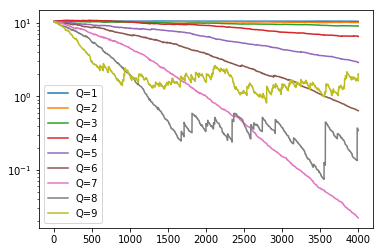

In [7]:
rk_various_quantiles = [[methods.SampledQuantileRK(*start_data, 
		quantile=q/10, samples=100),"Q="+str(q)] for q in range(1,10)]
plots.make_plot(rk_various_quantiles, iters=4000, soln=soln)
plt.show()

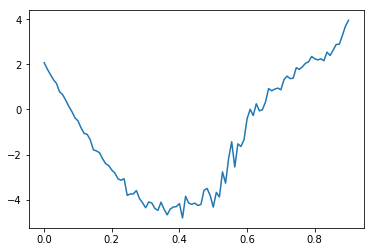

In [17]:
quantiles = np.linspace(0,0.9,num=100)
sgd_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileSGD(*start_data, quantile = q, samples=100) , 
                                     iters=4000, soln=soln)) for q in quantiles]
plt.plot(quantiles, sgd_error_by_quantile)
plt.show()

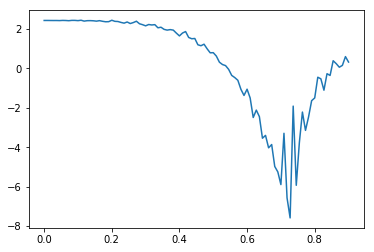

In [5]:
quantiles = np.linspace(0,0.9,num=100)
rk_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileRK(*start_data, quantile = q, samples=100) , 
                                     iters=5000, soln=soln)) for q in quantiles]
plt.plot(quantiles, rk_error_by_quantile)
plt.show()

Note that SGD is much less sensitive to the choice of quantile than is RK.   

---
Here we see a comparison of quantile based RK and quantile SGD.

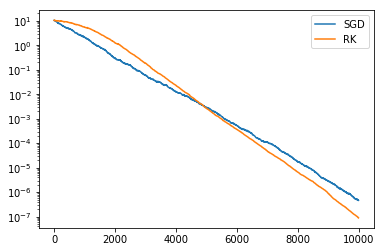

In [17]:
rk_vs_sgd = [[methods.SampledQuantileSGD(*start_data, 
		quantile=0.4, samples=100), "SGD"],
		[methods.SampledQuantileRK(*start_data, 
		quantile=0.7, samples=100), "RK"]]
plots.make_plot(rk_vs_sgd,iters=10000,soln=soln)
plt.show()

---
How does the sliding window method compare to subsampling rows?

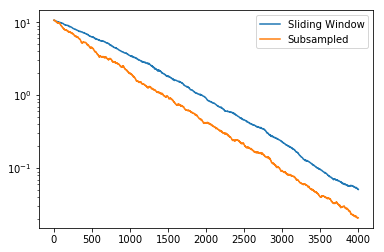

In [4]:
sw_sgd = methods.SW_SGD(*start_data, quantile = 0.4, window_size=100)
sampled_sgd = methods.SampledQuantileSGD(*start_data, quantile = 0.4, samples=100)
plots.make_plot([[sw_sgd, "Sliding Window"], [sampled_sgd,"Subsampled"]], iters=4000, soln=soln)
plt.show()

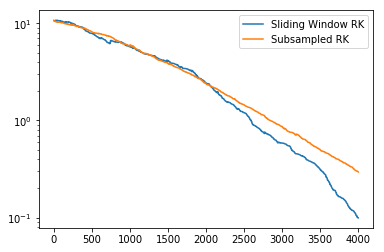

In [7]:
sw_rk = methods.SWQuantileRK(*start_data, quantile = 0.7, window_size=100)
sampled_rk = methods.SampledQuantileRK(*start_data, quantile = 0.6, samples=100)
plots.make_plot([[sw_rk, "Sliding Window RK"], [sampled_rk,"Subsampled RK"]], iters=4000, soln=soln)
plt.show()

How do the two methods compare as far as time?

In [55]:
from timeit import default_timer as timer

iters = 10000

sw_rk = methods.SWQuantileRK(*start_data, quantile = 0.7, window_size=100)
sampled_rk = methods.SampledQuantileRK(*start_data, quantile = 0.6, samples=100)

def time_method(method, iters):
    start = timer()
    for i in range(0,iters):
        method.do_iteration()
    end = timer()
    return end - start

sw_time = time_method(sw_rk,iters)
print("Time for sliding window: ", sw_time)

sampled_time = time_method(sampled_rk,iters)
print("Time for sampled rk: ", sampled_time)
print("sampled/sliding: ", sampled_time/sw_time)
    

Time for sliding window:  2.278233585995622
Time for sampled rk:  8.862363248015754
sampled/sliding:  3.890015186543205


---

What happens with SGD when we increase the fraction of corruptions?  By varying $\beta$ we can see how the behavior of SGD changes for various quantiles.

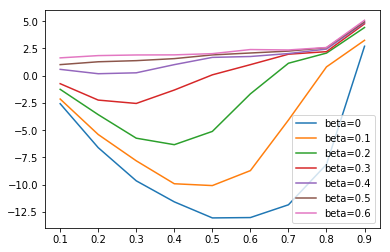

In [21]:
rows, cols = 50000, 100
start = np.zeros(cols)

for beta in [0,0.1,0.2,0.3,0.4,0.5,0.6]:
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start_data = [A,b,start]
    quantiles = np.linspace(0.1,0.9, num=9)
    sgd_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileSGD(*start_data, quantile = q, samples=100) , 
                                     iters=5000, soln=soln)) for q in quantiles]
    plt.plot(quantiles, sgd_error_by_quantile, label="beta="+str(beta))
plt.legend()
plt.show()

Note that for $\beta$ very small, the median appears to behave best among the quantiles.  As $\beta$ grows large, lower quantiles yield better behavior.

We can run the same experiment for median RK

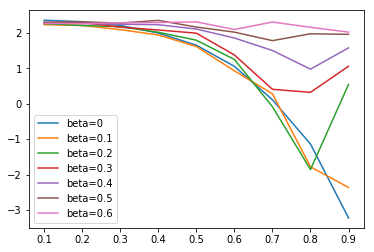

In [20]:
rows, cols = 50000, 100
start = np.zeros(cols)

for beta in [0,0.1,0.2,0.3,0.4,0.5,0.6]:
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start_data = [A,b,start]
    quantiles = np.linspace(0.1,0.9, num=9)
    sgd_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileRK(*start_data, quantile = q, samples=100) , 
                                     iters=2000, soln=soln)) for q in quantiles]
    plt.plot(quantiles, sgd_error_by_quantile, label="beta="+str(beta))
plt.legend()
plt.show()

---


Let's see what happens for less tall matrices.

In [31]:
def tall_test(rows, cols):
    beta = 0.2
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start = np.zeros(cols)
    start_data = [A,b,start]

    rk_vs_sgd = [[methods.SampledQuantileSGD(*start_data, 
    quantile=0.4, samples=100), "SGD"],
    [methods.SampledQuantileRK(*start_data, 
    quantile=0.7, samples=100), "RK"]]
    
    plots.make_plot(rk_vs_sgd,iters=10000,soln=soln)
    plt.show()
    
    

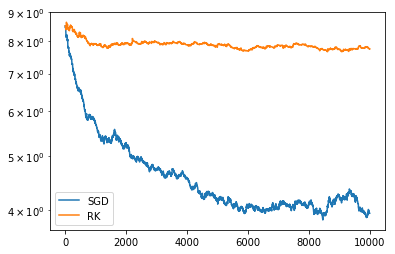

In [32]:
tall_test(200,100)

In this case, SGD (and to a lesser extent RK) appear to initially converge linearly while eventually reaching a convergence horizon.

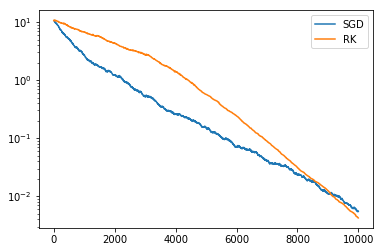

In [56]:
tall_test(500,100)

For slightly taller matrices, SGD and RK seem to avoid the convergence horizon.  These results agree with our theory which suggests that the aspect ratio of the matrix should be a sufficiently large constant.

For SGD, let's see how the aspect ratio of the matrix affects convergence properties.

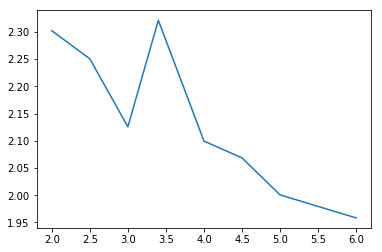

In [39]:
beta = 0.2
cols = 100

errors = []
aspects = [2,2.5,3,3.4,4,4.5,5,6]
for aspect in aspects:
    rows = math.floor(aspect*cols)
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start = np.zeros(cols)
    start_data = [A,b,start]

    errors.append(math.log(plots.final_error( methods.SampledQuantileRK(*start_data, quantile = 0.4, samples=100) , 
                                     iters=10000, soln=soln)))
plt.plot(aspects, errors)
plt.show()

---


How well does quantile SGD approximate OPT sgd?

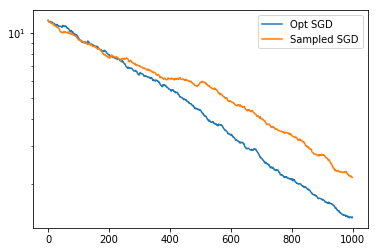

In [58]:
rows, cols = 5000, 100
beta = 0.2
errs = math.ceil(beta * rows);
A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
start = np.zeros(cols)
start_data = [A,b,start]

opt_sgd = methods.OptSGD(*start_data, soln=soln)
sampled_sgd = methods.SampledQuantileSGD(*start_data, quantile = 0.4, samples=100)
plots.make_plot([[opt_sgd, "Opt SGD"], [sampled_sgd,"Sampled SGD"]], iters=1000, soln=soln)
plt.show()

How does opt_sgd behave for various fractions of errors?

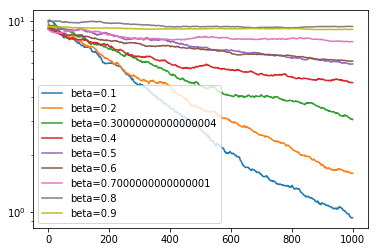

In [62]:
rows, cols = 1000, 100

for beta in np.linspace(0.1, 0.9, num=9):
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start = np.zeros(cols)
    start_data = [A,b,start]
    opt_sgd = methods.OptSGD(*start_data, soln=soln)
    plots.make_plot([[opt_sgd,"beta="+str(beta)]], iters=1000, soln=soln)
plt.show()